In [1]:
from ortools.sat.python import cp_model
from random import randint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (40,15)

# Data

In [2]:
n_hospitales = 5
n_pacientes = 500
n_camas_en_hospitales = [randint(10,100) for _ in range(n_hospitales)]
print(n_camas_en_hospitales)
n_camas_total = sum(n_camas_en_hospitales)
print(n_camas_total)

#localizacion
pacientes_loc = [(randint(0,100),randint(0,100)) for _ in range(n_pacientes)]
print(pacientes_loc)
hospitales_loc = [(randint(0,100),randint(0,100)) for _ in range(n_hospitales)]
print(hospitales_loc)
#grado de contagio
pacientes_contagio = [randint(1,5) for _ in range(n_pacientes)]
print(pacientes_contagio)

[69, 27, 16, 62, 100]
274
[(60, 10), (88, 28), (51, 25), (83, 48), (13, 76), (77, 23), (44, 14), (84, 7), (81, 41), (18, 3), (80, 85), (100, 94), (90, 32), (48, 38), (52, 100), (50, 92), (8, 66), (52, 21), (35, 86), (7, 20), (11, 5), (35, 11), (80, 60), (69, 2), (48, 100), (96, 24), (5, 99), (6, 73), (29, 48), (6, 50), (6, 97), (49, 7), (21, 11), (69, 73), (56, 55), (60, 28), (51, 24), (51, 100), (88, 2), (38, 82), (79, 93), (38, 92), (44, 18), (37, 6), (29, 13), (22, 69), (6, 52), (32, 41), (1, 50), (43, 81), (59, 10), (20, 31), (78, 41), (16, 62), (15, 51), (72, 64), (4, 38), (60, 55), (59, 43), (74, 76), (73, 11), (47, 38), (57, 4), (54, 51), (45, 37), (44, 8), (0, 16), (71, 39), (59, 70), (56, 54), (51, 69), (87, 79), (66, 17), (64, 34), (97, 89), (42, 47), (88, 2), (20, 94), (89, 35), (100, 72), (43, 15), (56, 93), (4, 74), (32, 11), (48, 7), (14, 8), (46, 74), (98, 86), (52, 47), (24, 0), (13, 77), (31, 3), (10, 99), (50, 20), (64, 100), (98, 2), (3, 73), (91, 66), (45, 99), (27,

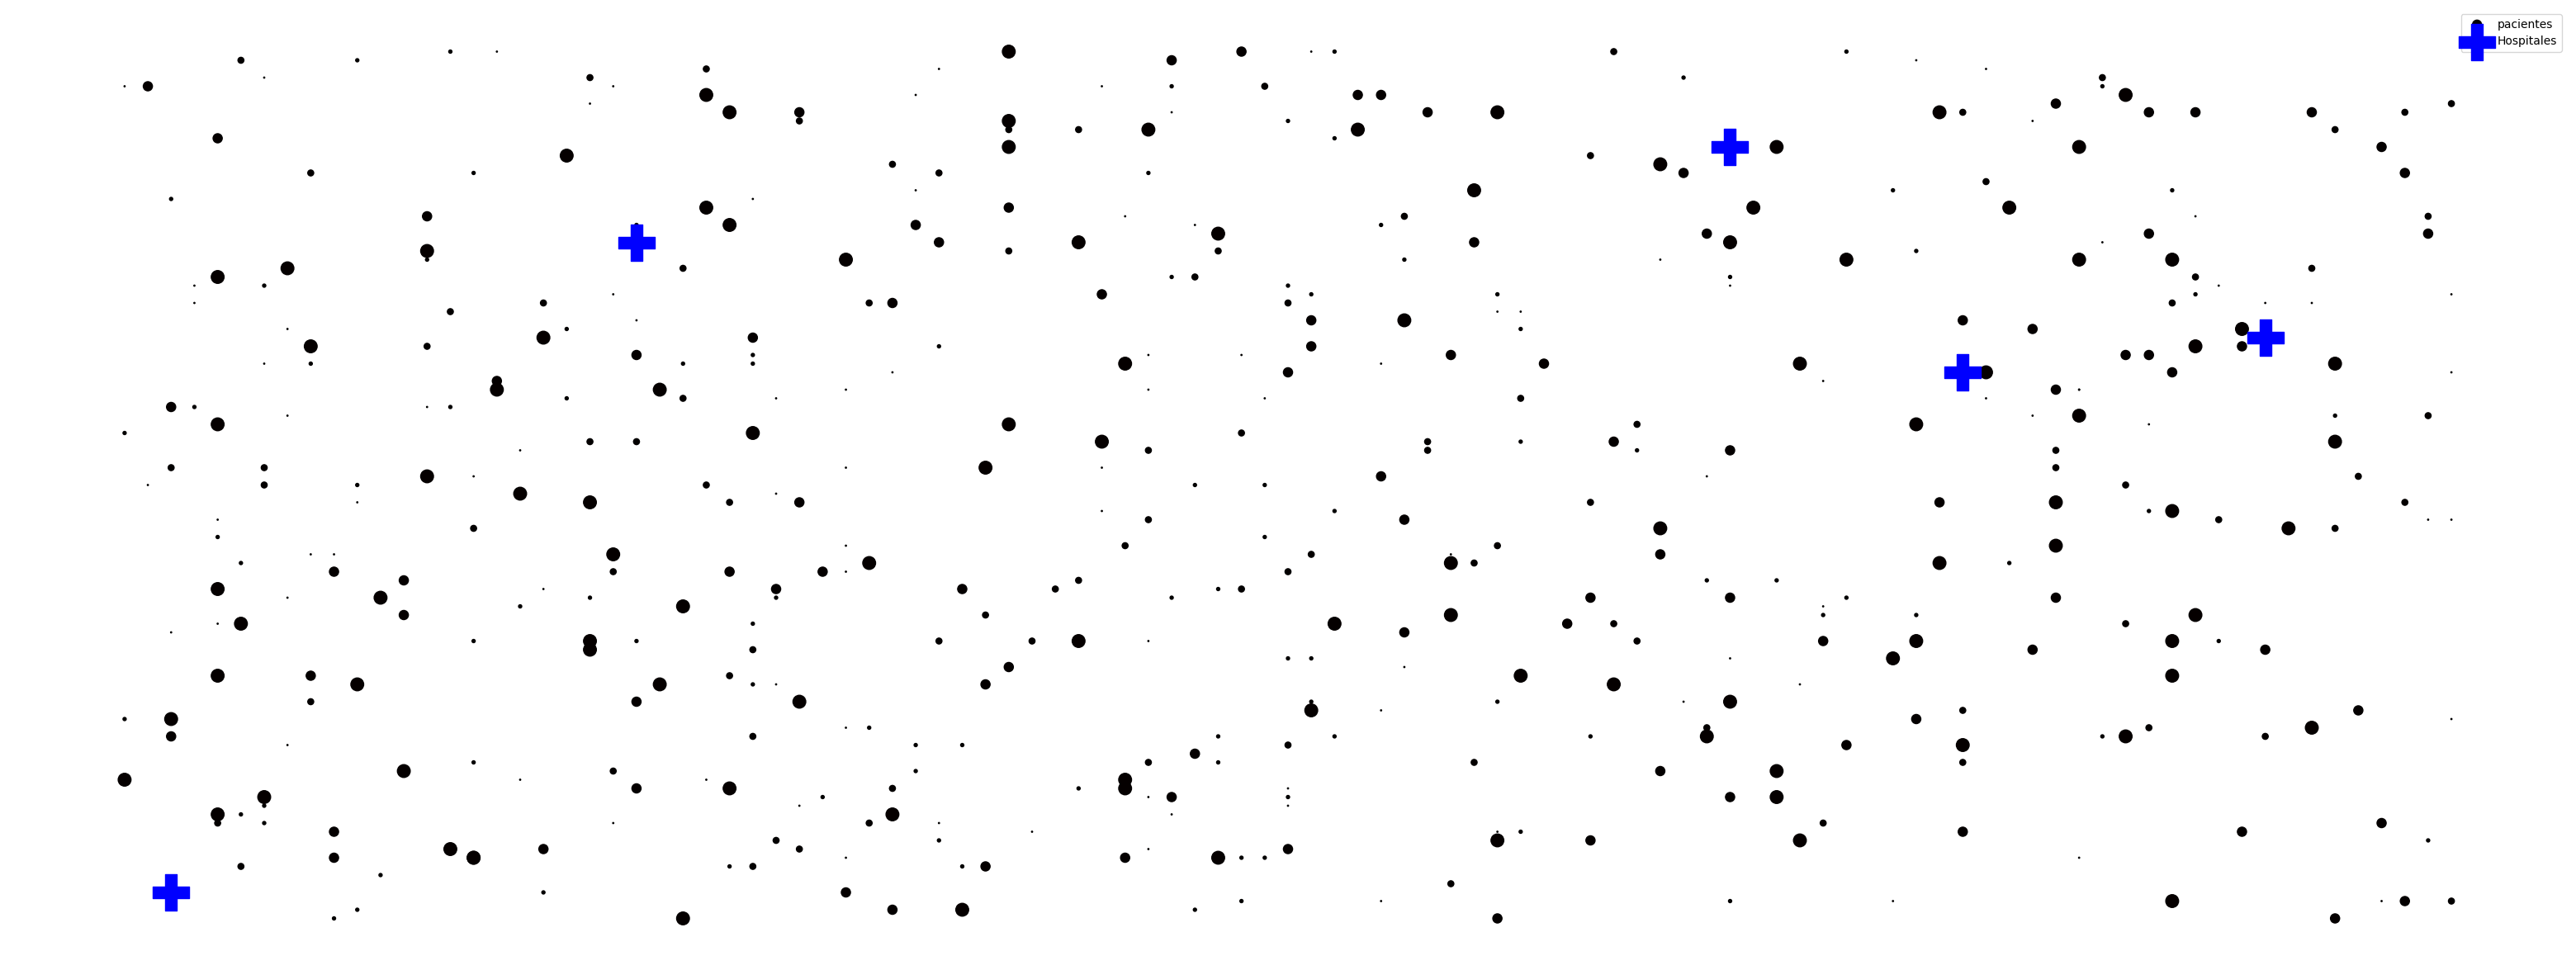

In [3]:
#visualización
tamano_contagio = [sev**3 for sev in pacientes_contagio]
color_contagio = ["#%02x0000" % sev for sev in pacientes_contagio]
plt.scatter(*zip(*pacientes_loc),s=tamano_contagio,c=color_contagio,label='pacientes')
plt.scatter(*zip(*hospitales_loc),s=1000,c='b',marker='P',label='Hospitales')
plt.legend()
plt.axis('off')
plt.show()

# CSP

In [4]:
#crear CSP
model = cp_model.CpModel()

#variables y dominios
x = {}
for i in range(n_hospitales):
  for j in range(n_camas_en_hospitales[i]):
    for k in range(n_pacientes):
      x[(i,j,k)] = model.NewBoolVar('x_'+str(i)+'_'+str(j)+'_'+str(k))

#restricciones
##hard constraints
##There must be at most a single person in every bed.
for i in range(n_hospitales):#para cada hospital
  for j in range(n_camas_en_hospitales[i]): #para todas las camas del hospital i
    model.Add(sum([x[(i,j,k)] for k in range(n_pacientes)]) <= 1)

##There must be at most a single bed assigned to every person.
for k in range(n_pacientes):#para todos los pacientes
  n_pacientes_en_camas_hospitales = []
  for i in range(n_hospitales):#para todos los hospitales
    n_pacientes_en_camas_hospitales += [sum([x[(i,j,k)] for j in range(n_camas_en_hospitales[i])])]
  model.Add(sum(n_pacientes_en_camas_hospitales) <= 1)

def dist(p1,p2):
  return int(((p1[0] - p2[0])**2 + (p1[1]-p2[1])**2)**0.5)

##soft constraints
v = []
for i in range(n_hospitales):
  for j in range(n_camas_en_hospitales[i]):
    for k in range(n_pacientes):
      #Every sick person should be placed into a bed: sumar los x[(i,j,k)] y maximizar
      #Every person should be handled by the nearest hospital: restar los x[(i,j,k)] por sus distancias, al maximizar se minimiza
      #Sick persons in severe condition should be handled first when there are not enough beds: sumar los x[(i,j,k)] por su gravedad
      #v += [x[(i,j,k)] - x[(i,j,k)] * dist(pacientes_loc[k],hospitales_loc[i]) + x[(i,j,k)] * pacientes_contagio[k]]
      #v += [x[(i,j,k)] * (1 - dist(pacientes_loc[k],hospitales_loc[i]) + pacientes_contagio[k])]
      v += [x[(i,j,k)] * (10 - int(0.25*dist(pacientes_loc[k],hospitales_loc[i]))+10*pacientes_contagio[k])]
#print(v)
model.Maximize(sum(v))

# Solver

In [5]:
solver = cp_model.CpSolver()
status = solver.Solve(model)
print(solver.StatusName(status))

print('# Pacientes atendidos:',solver.ObjectiveValue())
print('Tiempo:',solver.WallTime())
for i in range(n_hospitales):
  print('Hospital',i+1,hospitales_loc[i])
  for j in range(n_camas_en_hospitales[i]):
    for k in range(n_pacientes):
      if solver.Value(x[(i,j,k)]) == 1:
        print('\tPaciente',k+1,'en cama',j+1)
  print()

OPTIMAL
# Pacientes atendidos: 12087.0
Tiempo: 177.4593505
Hospital 1 (92, 67)
	Paciente 2 en cama 1
	Paciente 430 en cama 2
	Paciente 389 en cama 3
	Paciente 339 en cama 4
	Paciente 154 en cama 5
	Paciente 12 en cama 6
	Paciente 210 en cama 7
	Paciente 11 en cama 8
	Paciente 485 en cama 9
	Paciente 427 en cama 10
	Paciente 41 en cama 11
	Paciente 366 en cama 12
	Paciente 114 en cama 13
	Paciente 26 en cama 14
	Paciente 452 en cama 15
	Paciente 461 en cama 16
	Paciente 479 en cama 17
	Paciente 72 en cama 18
	Paciente 477 en cama 19
	Paciente 103 en cama 20
	Paciente 280 en cama 21
	Paciente 420 en cama 22
	Paciente 134 en cama 23
	Paciente 459 en cama 24
	Paciente 466 en cama 25
	Paciente 195 en cama 26
	Paciente 102 en cama 27
	Paciente 197 en cama 28
	Paciente 133 en cama 29
	Paciente 440 en cama 30
	Paciente 233 en cama 31
	Paciente 179 en cama 32
	Paciente 488 en cama 33
	Paciente 88 en cama 34
	Paciente 312 en cama 35
	Paciente 382 en cama 36
	Paciente 136 en cama 37
	Paciente 417

In [6]:
n = 0
for i in range(n_hospitales):
  for j in range(n_camas_en_hospitales[i]):
    for k in range(n_pacientes):
      if solver.Value(x[(i,j,k)]) == 1:
        n+=1
print('# Pacientes asignados:', n)

# Pacientes asignados: 274


In [7]:
plot_lineas = [[] for _ in range(n_hospitales)]
for i in range(n_hospitales):
  for j in range(n_camas_en_hospitales[i]):
    for k in range(n_pacientes):
      if solver.Value(x[(i,j,k)]) == 1:
        linea_abcisa = [hospitales_loc[i][0],pacientes_loc[k][0]]
        linea_ordenada = [hospitales_loc[i][1],pacientes_loc[k][1]]
        plot_lineas[i].append([linea_abcisa,linea_ordenada])

In [8]:
pacientes_contagio

[2,
 5,
 2,
 5,
 2,
 4,
 1,
 1,
 2,
 2,
 3,
 3,
 2,
 3,
 2,
 2,
 5,
 2,
 3,
 1,
 2,
 1,
 1,
 2,
 4,
 4,
 3,
 2,
 4,
 3,
 1,
 2,
 1,
 1,
 3,
 5,
 5,
 1,
 3,
 4,
 3,
 5,
 3,
 4,
 1,
 1,
 3,
 5,
 1,
 1,
 1,
 5,
 5,
 4,
 1,
 5,
 5,
 2,
 3,
 5,
 3,
 2,
 3,
 4,
 2,
 1,
 5,
 2,
 1,
 3,
 4,
 4,
 4,
 3,
 4,
 1,
 5,
 1,
 1,
 1,
 5,
 4,
 5,
 3,
 2,
 5,
 3,
 2,
 2,
 5,
 4,
 4,
 2,
 3,
 3,
 4,
 1,
 4,
 4,
 2,
 5,
 5,
 5,
 1,
 4,
 5,
 1,
 4,
 2,
 3,
 3,
 5,
 5,
 3,
 3,
 1,
 5,
 5,
 1,
 1,
 3,
 2,
 1,
 5,
 1,
 2,
 4,
 2,
 4,
 5,
 4,
 2,
 3,
 3,
 5,
 5,
 4,
 3,
 4,
 1,
 1,
 2,
 4,
 1,
 1,
 1,
 2,
 5,
 5,
 3,
 4,
 3,
 2,
 2,
 1,
 5,
 5,
 1,
 3,
 4,
 3,
 5,
 1,
 3,
 4,
 2,
 1,
 1,
 1,
 2,
 3,
 2,
 2,
 3,
 3,
 4,
 4,
 5,
 4,
 4,
 1,
 1,
 5,
 5,
 3,
 3,
 1,
 1,
 1,
 3,
 5,
 1,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 4,
 4,
 1,
 4,
 3,
 1,
 4,
 2,
 1,
 4,
 3,
 1,
 5,
 5,
 2,
 4,
 2,
 5,
 2,
 5,
 2,
 2,
 2,
 3,
 4,
 2,
 3,
 2,
 4,
 2,
 2,
 1,
 4,
 3,
 1,
 3,
 5,
 1,
 5,
 3,
 2,
 5,
 3,
 5,
 3,
 5,
 2,
 4,
 2,
 5,
 3,


In [9]:
[int(sev * 255 / 5) for sev in pacientes_contagio]

[102,
 255,
 102,
 255,
 102,
 204,
 51,
 51,
 102,
 102,
 153,
 153,
 102,
 153,
 102,
 102,
 255,
 102,
 153,
 51,
 102,
 51,
 51,
 102,
 204,
 204,
 153,
 102,
 204,
 153,
 51,
 102,
 51,
 51,
 153,
 255,
 255,
 51,
 153,
 204,
 153,
 255,
 153,
 204,
 51,
 51,
 153,
 255,
 51,
 51,
 51,
 255,
 255,
 204,
 51,
 255,
 255,
 102,
 153,
 255,
 153,
 102,
 153,
 204,
 102,
 51,
 255,
 102,
 51,
 153,
 204,
 204,
 204,
 153,
 204,
 51,
 255,
 51,
 51,
 51,
 255,
 204,
 255,
 153,
 102,
 255,
 153,
 102,
 102,
 255,
 204,
 204,
 102,
 153,
 153,
 204,
 51,
 204,
 204,
 102,
 255,
 255,
 255,
 51,
 204,
 255,
 51,
 204,
 102,
 153,
 153,
 255,
 255,
 153,
 153,
 51,
 255,
 255,
 51,
 51,
 153,
 102,
 51,
 255,
 51,
 102,
 204,
 102,
 204,
 255,
 204,
 102,
 153,
 153,
 255,
 255,
 204,
 153,
 204,
 51,
 51,
 102,
 204,
 51,
 51,
 51,
 102,
 255,
 255,
 153,
 204,
 153,
 102,
 102,
 51,
 255,
 255,
 51,
 153,
 204,
 153,
 255,
 51,
 153,
 204,
 102,
 51,
 51,
 51,
 102,
 153,
 102,
 102,
 1

[8, 125, 8, 125, 8, 64, 1, 1, 8, 8, 27, 27, 8, 27, 8, 8, 125, 8, 27, 1, 8, 1, 1, 8, 64, 64, 27, 8, 64, 27, 1, 8, 1, 1, 27, 125, 125, 1, 27, 64, 27, 125, 27, 64, 1, 1, 27, 125, 1, 1, 1, 125, 125, 64, 1, 125, 125, 8, 27, 125, 27, 8, 27, 64, 8, 1, 125, 8, 1, 27, 64, 64, 64, 27, 64, 1, 125, 1, 1, 1, 125, 64, 125, 27, 8, 125, 27, 8, 8, 125, 64, 64, 8, 27, 27, 64, 1, 64, 64, 8, 125, 125, 125, 1, 64, 125, 1, 64, 8, 27, 27, 125, 125, 27, 27, 1, 125, 125, 1, 1, 27, 8, 1, 125, 1, 8, 64, 8, 64, 125, 64, 8, 27, 27, 125, 125, 64, 27, 64, 1, 1, 8, 64, 1, 1, 1, 8, 125, 125, 27, 64, 27, 8, 8, 1, 125, 125, 1, 27, 64, 27, 125, 1, 27, 64, 8, 1, 1, 1, 8, 27, 8, 8, 27, 27, 64, 64, 125, 64, 64, 1, 1, 125, 125, 27, 27, 1, 1, 1, 27, 125, 1, 64, 64, 125, 125, 125, 125, 125, 64, 64, 1, 64, 27, 1, 64, 8, 1, 64, 27, 1, 125, 125, 8, 64, 8, 125, 8, 125, 8, 8, 8, 27, 64, 8, 27, 8, 64, 8, 8, 1, 64, 27, 1, 27, 125, 1, 125, 27, 8, 125, 27, 125, 27, 125, 8, 64, 8, 125, 27, 125, 125, 64, 125, 27, 125, 125, 27, 64, 8, 8, 

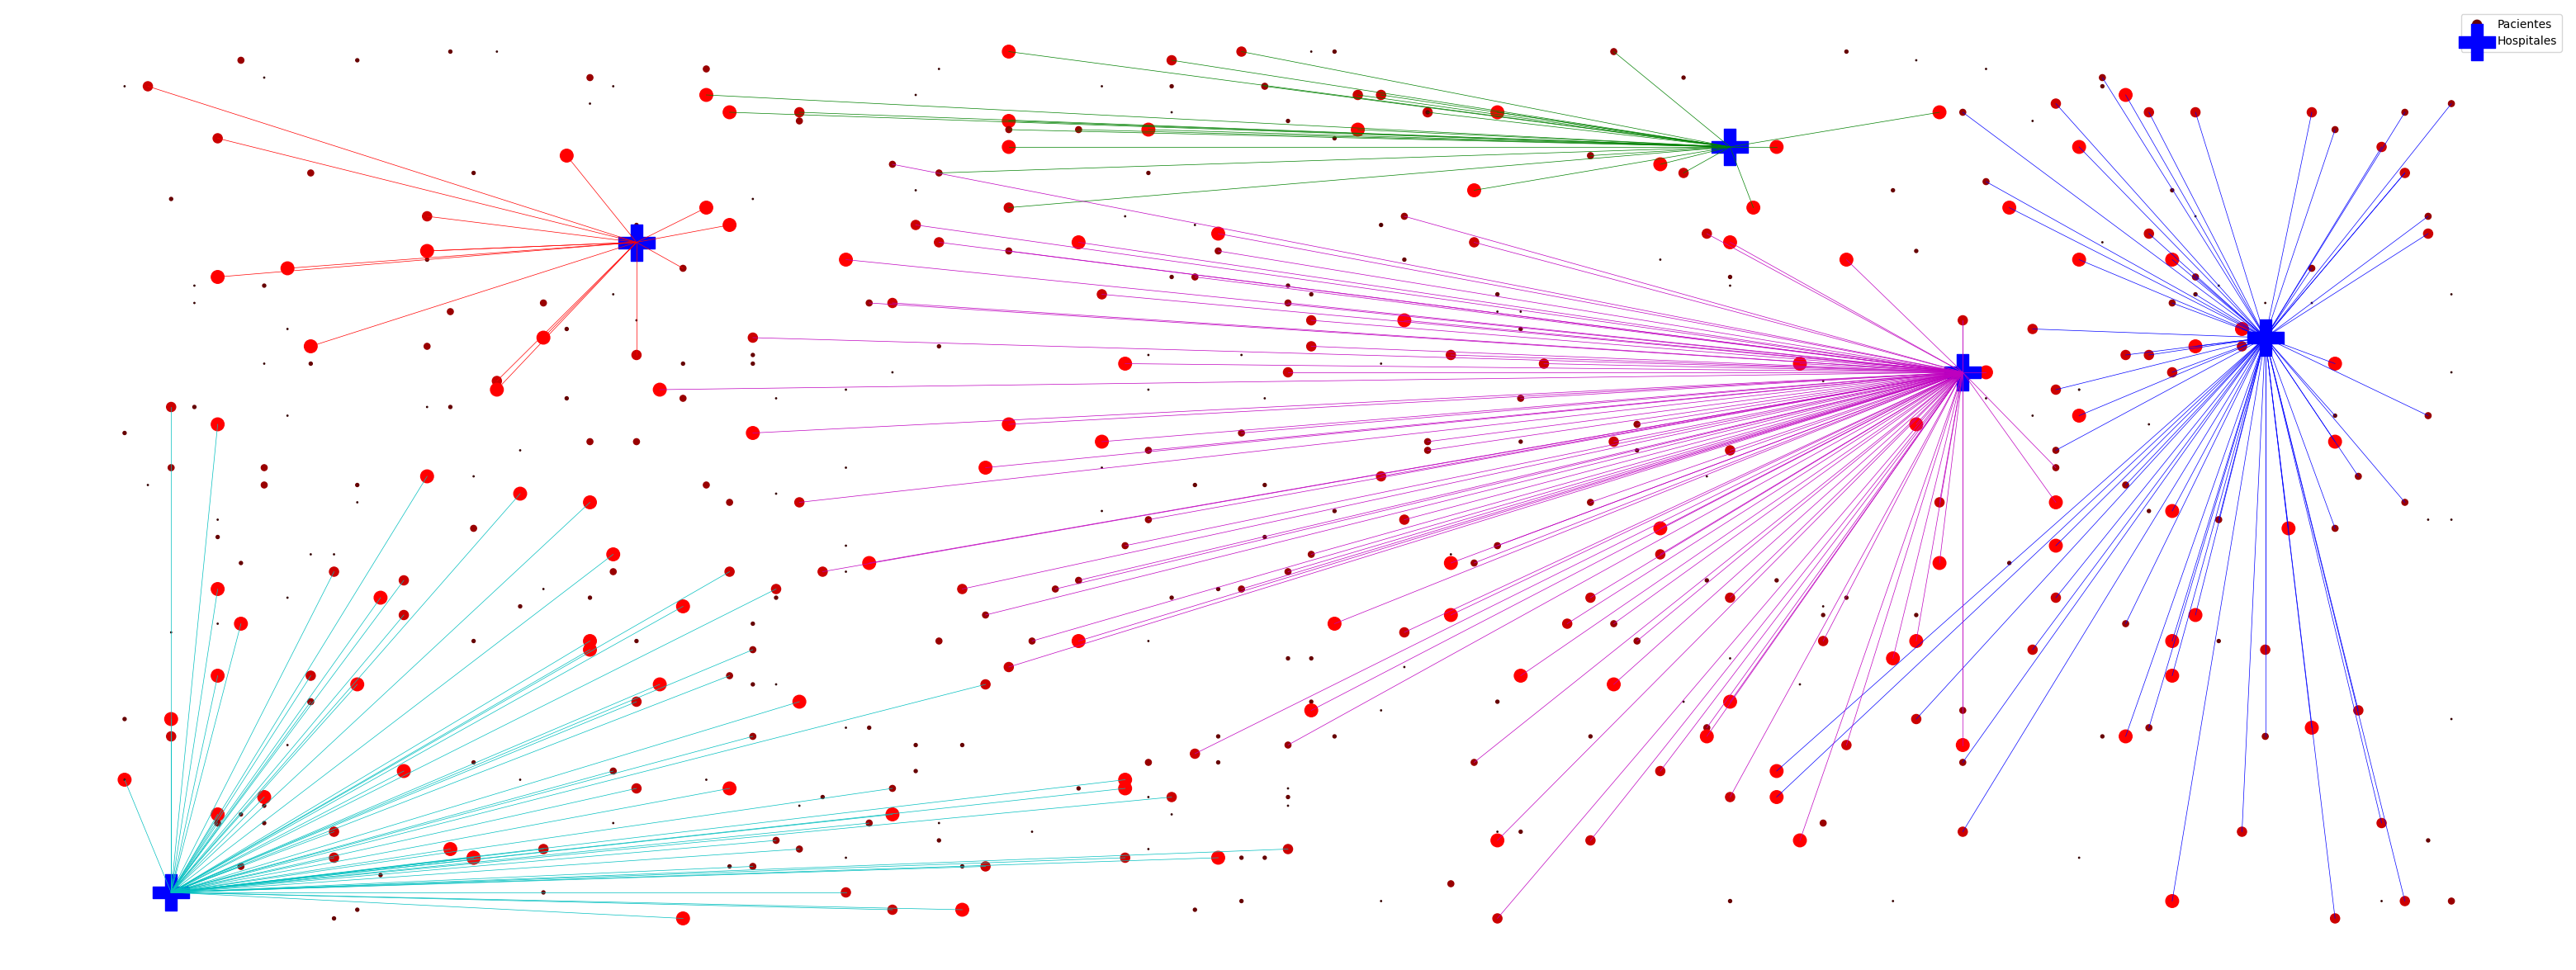

In [10]:
from itertools import cycle

#sombra de 255 posibles valores en RGB
sombra_contagio = [int(sev * 255 / 5) for sev in pacientes_contagio]
#color para cada punto
color_contagio = ['#%02x0000'%sev for sev in sombra_contagio]
#tamaño para cada punto
tamano_contagio = [k**3 for k in pacientes_contagio]
print(tamano_contagio)
#plot para pacientes
plt.scatter(*zip(*pacientes_loc),s=tamano_contagio,c=color_contagio,label='Pacientes')
print(color_contagio)
#plot para hospitales
plt.scatter(*zip(*hospitales_loc),s=1000,c='b',marker='P',label='Hospitales')
#ploteo de líneas por colores, un color por hospital
colores = cycle('bgrcmk')
for i in range(n_hospitales):#para cada hospital recuperar sus líneas y ponerles un color
  c = next(colores)
  for (x_,y_) in plot_lineas[i]:
    plt.plot(x_,y_,c=c,linewidth=0.5)
#
plt.legend()
plt.axis('off')
plt.show()